# Import

In [1]:
# Podstawowe biblioteki
import pandas as pd
import re
import string
import matplotlib.pyplot as plt
import numpy as np

# Biblioteka SHAP
import shap

# Biblioteka do analizy tekstu, oraz do klasyfikacji
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('vader_lexicon')

# Bilbioteka WordCloud
from wordcloud import WordCloud

# Biblioteka do klasyfikacji, oraz odpowiednie modele
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from catboost import CatBoostClassifier

# Biblioteka Transformers
import transformers
from transformers import BertTokenizer
from transformers import TFAutoModel

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/bkonopka/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/bkonopka/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# Preprocessing

In [2]:
# Załadowanie danych
data = pd.read_csv('realdonaldtrump.csv')
dataOriginal = data.copy()

# Usunięcie url z treści
def remove_url(content):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',content)

# Usunięcie linków twittera do zdjęć
def remove_pic(content):
	pic = re.compile(r'pic.twitter.com/\S+')
	return pic.sub(r'',content)

# Usunięcie mentionów
def remove_ment(content):
    mention1 = re.compile(r'@ \w+')
    mention2 = re.compile(r'@\w+')
    content = mention1.sub(r'',content)
    return mention2.sub(r'',content)

# Usunięcie znaków interpunkcyjnych
def remove_punct(content):
    table = str.maketrans('', '', string.punctuation)
    return content.translate(table)

# Usunięcie html
def remove_html(content):
    html=re.compile(r'<.*?>')
    return html.sub(r'',content)

# Usunięcie emotikonów
def remove_emoji(content):
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"
        u"\U0001F300-\U0001F5FF"
        u"\U0001F680-\U0001F6FF"
        u"\U0001F1E0-\U0001F1FF"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', content)

# Dekontrakcja
def decontraction(content):
    content = re.sub(r"won\'t", " will not", content)
    content = re.sub(r"won\'t've", " will not have", content)
    content = re.sub(r"can\'t", " can not", content)
    content = re.sub(r"don\'t", " do not", content)
    content = re.sub(r"can\'t've", " can not have", content)
    content = re.sub(r"ma\'am", " madam", content)
    content = re.sub(r"let\'s", " let us", content)
    content = re.sub(r"ain\'t", " am not", content)
    content = re.sub(r"shan\'t", " shall not", content)
    content = re.sub(r"sha\n't", " shall not", content)
    content = re.sub(r"o\'clock", " of the clock", content)
    content = re.sub(r"y\'all", " you all", content)
    content = re.sub(r"n\'t", " not", content)
    content = re.sub(r"n\'t've", " not have", content)
    content = re.sub(r"\'re", " are", content)
    content = re.sub(r"\'s", " is", content)
    content = re.sub(r"\'d", " would", content)
    content = re.sub(r"\'d've", " would have", content)
    content = re.sub(r"\'ll", " will", content)
    content = re.sub(r"\'ll've", " will have", content)
    content = re.sub(r"\'t", " not", content)
    content = re.sub(r"\'ve", " have", content)
    content = re.sub(r"\'m", " am", content)
    content = re.sub(r"\'re", " are", content)
    return content

# Separacja słów od liczb
def seperate_alphanumeric(content):
    words = content
    words = re.findall(r"[^\W\d_]+|\d+", words)
    return " ".join(words)

# Znalezienie powtarzających się znaków
def cont_rep_char(content):
    tchr = content.group(0)
    if len(tchr) > 1:
        return tchr[0:2]

# Usunięcie powtarzających się znaków
def unique_char(rep, content):
    substitute = re.sub(r'(\w)\1+', rep, content)
    return substitute

# Usunięcie stop words
stop_words=stopwords.words('english')
stemmer=SnowballStemmer('english')

def remove_stopwords(text):
    tokens = []
    for token in text.split():
        if token not in stop_words:
            tokens.append(token)
    return " ".join(tokens)

# Stemming
def stem(text):
    tokens = []
    for token in text.split():
        tokens.append(stemmer.stem(token))
    return " ".join(tokens)

# Ustawienie wszystkich liter na małe
data['content'] = data['content'].apply(lambda x : x.lower())

# Usunięcie zbędnych elementów
data['content'] = data['content'].apply(lambda x : remove_pic(x))
data['content'] = data['content'].apply(lambda x : remove_url(x))
data['content'] = data['content'].apply(lambda x : remove_ment(x))
data['content'] = data['content'].apply(lambda x : remove_punct(x))
data['content'] = data['content'].apply(lambda x : remove_emoji(x))

# Reszta cyszczenia
data['content'] = data['content'].apply(lambda x : decontraction(x))
data['content'] = data['content'].apply(lambda x : seperate_alphanumeric(x))
data['content'] = data['content'].apply(lambda x : unique_char(cont_rep_char,x))
data['content'] = data['content'].apply(lambda x : remove_stopwords(x))
#data['content'] = data['content'].apply(lambda x : stem(x))

# Usunięcie duplikatów
data = data.drop_duplicates(subset=['content'])

# Usunięcie pustych wartości
data = data.dropna(subset=['content'])

# Usunięcie zbędnych kolumn
data = data.drop(['link','mentions','hashtags', 'retweets', 'favorites', 'date'], axis=1)

# NLP model

In [3]:
# Utworenie modelu
sia = SentimentIntensityAnalyzer()

# Obliczenie sentymentu
def compute_sentiment(sentence):
    result = sia.polarity_scores(sentence)
    return result['compound'], result['neg'], result['neu'], result['pos']

# Obliczenie sentymentu dla każdego tweeta
dataSentiment = data.copy()
dataSentiment['compound'], dataSentiment['negative'], dataSentiment['neutral'], dataSentiment['positive'] = zip(*data['content'].apply(compute_sentiment))

# Kategoryzacja sentymentu
def categorize_sentiment(compound):
    if compound <= -0.01:
        return 'negative'
    elif compound >= 0.01:
        return 'positive'
    else:
        return 'neutral'
dataSentiment['sentiment'] = dataSentiment['compound'].apply(categorize_sentiment)

# Prezentacja danych
pd.set_option('display.max_colwidth', None)
dataSentiment.sample(5)

,id,content,compound,negative,neutral,positive,sentiment
31404,831621079747723264,remarks president trump signing hj resolution 41,0.0000,0.000,1.000,0.000,neutral
34084,991995845120753664,despite already signed detailed letter admitting affair prior violation ms clifford attorney private agreement money campaign campaign contributions played roll transaction,0.3400,0.119,0.672,0.209,positive
3581,254281529969238016,friend called recast race,0.4939,0.000,0.484,0.516,positive
27267,685302951821340672,great showed courage going burlington gop candidate would tonight,0.8074,0.000,0.490,0.510,positive
29425,748141420528140288,must fight harder american worker china many others taking advantage us terrible trade pacts,-0.5719,0.305,0.588,0.107,negative


# Data presentation

In [4]:
# Przykładowe dane
pd.set_option('display.max_colwidth', None)
data.sample(5)

,id,content
35508,1047175026259189761,proud great first lady loves
34019,988509958089166848,great stat since january 2017 number people forced use food stamps 19 million american people finally back work
39295,1174499065335144448,polls brand new polls show little support impeachment waste time especially soo much good could done including prescription drug price reduction healthcare infrastructure etc
13291,412591535033966592,wow injohn beale top person government climate change epa total fraud admitted say
7621,315948550360018947,followed business advice business roof great


Number of positive tweets: 23629


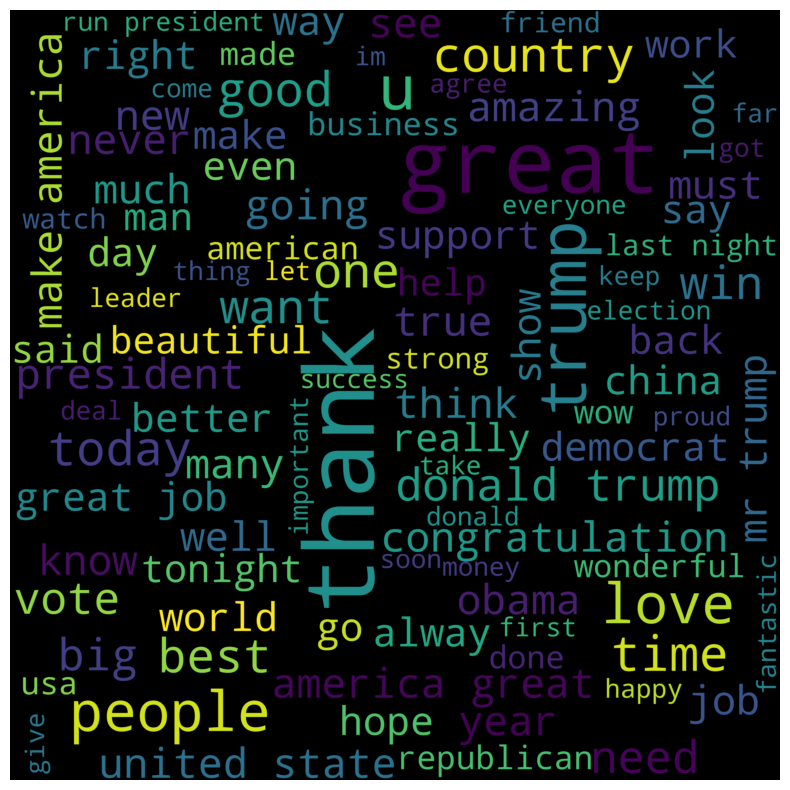

Number of negative tweets: 10473


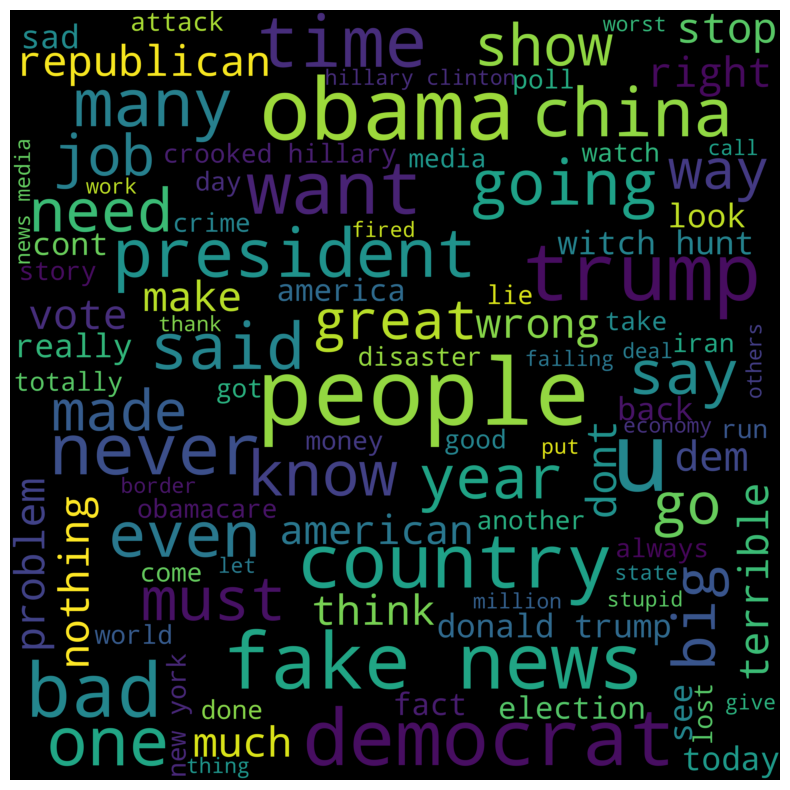

Number of neutral tweets: 6204


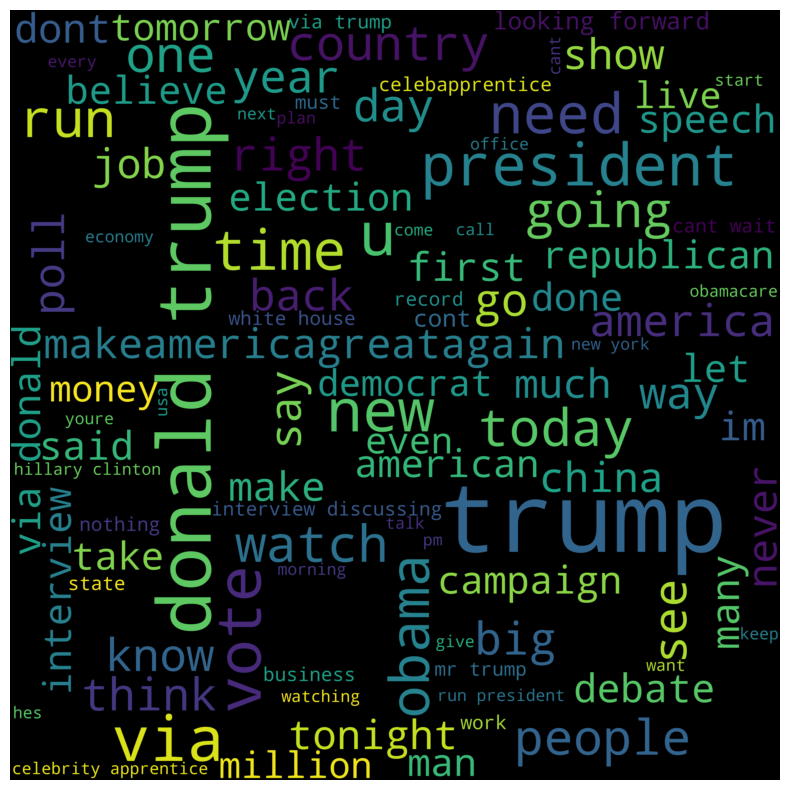

In [5]:
# Prezentacja najczęściej występujących słów w kategoriach sentymentu
for sentiment in ['positive', 'negative', 'neutral']:
    sentiment_data = dataSentiment[dataSentiment['sentiment'] == sentiment]
    print(f"Number of {sentiment} tweets: {sentiment_data.shape[0]}")
    word_cloud_text = ' '.join(sentiment_data['content'] )
    wordcloud = WordCloud(
        max_font_size=100,
        max_words=100,
        background_color="black",
        scale=10,
        width=800,
        height=800
    ).generate(word_cloud_text)
    plt.figure(figsize=(10,10))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

# SHAP analysis

In [6]:
tokenizer = BertTokenizer.from_pretrained('distilbert-base-uncased')

train_tokens = tokenizer(
    dataSentiment['content'].tolist(), 
    max_length=256, 
    truncation=True, 
    padding='max_length', 
    add_special_tokens=True, 
    return_tensors='np'
)
train_tokens = train_tokens['input_ids']

# Przygotowanie danych do modelu
X = train_tokens[:]
y = dataSentiment['sentiment']

# Zakodowanie etykiet tekstowych na numeryczne
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Podział na zbiór treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DistilBertTokenizer'. 
The class this function is called from is 'BertTokenizer'.


[[  101  5791  2995 ...     0     0     0]
 [  101  2577 14233 ...     0     0     0]
 [  101  2343  1016 ...     0     0     0]
 ...
 [  101  2160  8037 ...     0     0     0]
 [  101  3422  2651 ...     0     0     0]
 [  101  2113  2115 ...     0     0     0]]


In [7]:
# Trening modelu Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Trening modelu XGBoost
xgb_model = xgb.XGBClassifier(random_state=42)
xgb_model.fit(X_train, y_train)

# Trening modelu CatBoost
catboost_model = CatBoostClassifier(random_state=42, verbose=0)
catboost_model.fit(X_train, y_train)

# Predykcje na zbiorze testowym
y_pred_rf = rf_model.predict(X_test)
y_pred_xgb = xgb_model.predict(X_test)
y_pred_catboost = catboost_model.predict(X_test)

# Raport klasyfikacji
print("Random Forest")
print(classification_report(y_test, y_pred_rf, target_names=label_encoder.classes_))

# Raport klasyfikacji
print("XGBoost")
print(classification_report(y_test, y_pred_xgb, target_names=label_encoder.classes_))

# Raport klasyfikacji
print("CatBoost")
print(classification_report(y_test, y_pred_catboost, target_names=label_encoder.classes_))

Random Forest
              precision    recall  f1-score   support

    negative       0.46      0.12      0.18      2106
     neutral       0.57      0.13      0.21      1296
    positive       0.60      0.93      0.73      4660

    accuracy                           0.59      8062
   macro avg       0.54      0.39      0.38      8062
weighted avg       0.56      0.59      0.51      8062

XGBoost
              precision    recall  f1-score   support

    negative       0.52      0.28      0.36      2106
     neutral       0.56      0.22      0.31      1296
    positive       0.64      0.88      0.74      4660

    accuracy                           0.62      8062
   macro avg       0.57      0.46      0.47      8062
weighted avg       0.60      0.62      0.57      8062

CatBoost
              precision    recall  f1-score   support

    negative       0.52      0.25      0.33      2106
     neutral       0.57      0.16      0.25      1296
    positive       0.63      0.90      0.74 

In [11]:
test_string = "make amercia great again"

test_string_tokenizer = tokenizer(
    test_string, 
    max_length=256, 
    truncation=True, 
    padding='max_length', 
    add_special_tokens=True, 
    return_tensors='np'
)
test_string_tokenizer = test_string_tokenizer['input_ids']

test1 = rf_model.predict(test_string_tokenizer)
test2 = xgb_model.predict(test_string_tokenizer)
test3 = catboost_model.predict(test_string_tokenizer)

print(label_encoder.inverse_transform(test1))
print(label_encoder.inverse_transform(test2))
print(label_encoder.inverse_transform(test3))

['positive']
['positive']
['positive']


/home/bkonopka/miniconda3/envs/env39/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [12]:
# Analiza SHAP dla RandomForest
explainer_rf = shap.TreeExplainer(rf_model)
shap_values_rf = explainer_rf.shap_values(X_test)

# # Wizualizacja wartości SHAP dla predykcji dla RandomForest
# shap.summary_plot(shap_values_rf, X_test)

# # Analiza SHAP dla XGBoost
# explainer_xgb = shap.TreeExplainer(xgb_model)
# shap_values_xgb = explainer_xgb.shap_values(X_test)

# # Wizualizacja wartości SHAP dla predykcji dla XGBoost
# shap.summary_plot(shap_values_xgb, X_test)

# # Analiza SHAP dla CatBoost
# explainer = shap.TreeExplainer(catboost_model)
# shap_values = explainer.shap_values(X_test)

# # Wizualizacja wartości SHAP dla predykcji dla CatBoost
# shap.summary_plot(shap_values, X_test, feature_names=X.columns)

# # Zapisanie wyników do nowego pliku CSV
# data['number'] = [i+1 for i, _ in enumerate(data.iterrows())]
# df = data[['number'] + list(data.columns[:-1])]
# df.to_csv('tweets_sentiment_with_model.csv', index=False)
# print(df.head())

2024-06-12 19:00:07.390214: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-12 19:00:08.168980: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Conclusions